# Image Captioning using Transformers

Author: Cláudia Magliano

Date:15/07/2024

This notebook is based on generating captions for any image. This article includes all the details and procedure that is followed for finding a right caption for the image.

This includes -

1. Using Pre-trained Mobilenet Architecture to convert images to vectors that can be fed to the cross attention layer in the transformer decoder architecture.

2. Understanding the process of conversion of text into tokens and further into embeddings. (Here, I am using TextVectorizer, although if you want you can use other Tokenizers like BERT Tokenizer which internally follows sentence piece tokenizer which uses subword tokenization.)

3. Understanding the concept of Positional Embeddings and why it is used and how it allows transformer to replace sequential nature of RNN based architecture.

4. Understanding Global Self Attention, Causal Self Attention and Cross Attention and when to use what.

5. Creating the entire model architecture and comparing it previous architectures (i.e. the architectures that were used before the existance of Transformer). Hint: Previously, in order to calculate attention weights, a multi layer perceptron layer was used but now this all can be done by scaled dot product attention, which is just simple dot product between vectors.

6. Evaluating the model using Masked Loss function, BLEU score, ROUGE score, and F-score.

7. Visualising the attention of each word generated on different parts of the image i.e. understanding that while generating a word, what are image features model is looking at.

In [5]:
!pip install -q 'tensorflow-text==2.15.*'
!pip install -q tensorflow_datasets
!pip install -q einops

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_datasets as tfds

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def get_data(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

def get_dataset(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')
    captions = (path/'Flickr8k.token.txt').read_text().splitlines()
    captions = [cap.split('\t') for cap in captions]
    captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)

    train_imgs_path = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
    test_imgs_path = (path/'Flickr_8k.testImages.txt').read_text().splitlines()

    train_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in train_imgs_path]
    test_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in test_imgs_path]

    train_raw = tf.data.experimental.from_list(train_caps)
    test_raw = tf.data.experimental.from_list(test_caps)

    return train_raw, test_raw

In [9]:
get_data()
train_raw, test_raw = get_dataset()

2340801/2340801 [==============================] - 0s 0us/step


In [10]:
print(len(train_raw), len(test_raw))
print(train_raw.element_spec)

for img_path, captions in train_raw.take(1):
    break

print(img_path)
print(captions)

6000 1000
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))
tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [11]:
image_shape = (224, 224, 3)
feature_extractor = tf.keras.applications.MobileNetV3Small(input_shape = image_shape, include_preprocessing = True, include_top = False)
feature_extractor.trainable = False

4334752/4334752 [==============================] - 1s 0us/step


In [12]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

In [13]:
img = load_img(img_path.numpy().decode('utf-8'))
print(img.shape)
print(feature_extractor(img[tf.newaxis, ...]).shape)

(224, 224, 3)
(1, 7, 7, 576)


**Image Vectorization:**

Here, I am using Mobilenet-v3 small pretrained (on Imagenet dataset) model to convert image to vectors. You can also use Resnet-50, Inception-net or any pretrained deep convnet model. We do not need the output in form of classes (if trained on Imagenet dataset then 1000 classes), so we can remove the top layers from the image vectorizer. We can either train the image vectorizer along with model or can keep the weights fixed or train only few layers of it. Here, I have kept its weights as fixed.

Now, upto which layer of the pre-trained model to pick for our image vectorizer is actually upto us.

Just remember: The top layers provide more salient features of the image but if we want more detailed features, the lower level layers capture those intricate details.

**Text Vectorization:**

Converting text into tokens in one the most important things the pre-processing of data.

We can create our own function to convert text into tokens by learning vocab (set of all unique words in the text). We can also provide a maximum vocab size which ensure that the number of unique ids will be less than or equal to it. In this case, the top maximum_vocab_size occuring words are included in vocab.

The vocab also includes other reserved tokens like

pad token : For padding the sequence so that the batch of input sentences that we input to the model is of fixed shape.

unk token : This token is for the unknown words that are not present in the vocab.

[START] token : This token indicates the start of a sentence.


[END] token: This indicates the end of a sentence.

 I am using TextVectorization layer in Tensorflow that does the same for us. You can also use StringLookup layer for the same. I have also used the StringLookup layer for converting token ids back to text.

In [14]:
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.join(['[START]',text,'[END]'], separator = ' ')
    return text

In [15]:
standardize('A black dog is running after a white dog in the snow .')

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] a black dog is running after a white dog in the snow  [END]'>

In [16]:
vocab_size = 5000
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                               standardize = standardize,
                                               ragged = True)

vectorizer.adapt(train_raw.map(lambda img_path, cap: cap).unbatch().batch(1024))

In [17]:
print(vectorizer.get_vocabulary()[:10])

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']


In [18]:
text_to_id_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '')
id_to_text_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '', invert = True)

I have also used a function which converts tokens back to text such that it filters out all the reserved tokens except [UNK] token.

In [19]:
def id_to_text(token_ids, reserved_tokens = ['', '[UNK]', '[START]', '[END]']):
    words = id_to_text_vectorizer(token_ids)
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)
    bad_mask = tf.strings.regex_full_match(words, bad_tokens_re)
    words = tf.ragged.boolean_mask(words, ~bad_mask)

    return tf.strings.reduce_join(words, axis = -1, separator = ' ')

def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ...  -> (b c) ...', c = captions_shape['c'])
    return images, captions

In [20]:
for img, cap in train_raw.batch(1024).take(1):
    break

print(img.shape)
print(cap.shape)
img_serialize, cap_serialize = serialize_data(img, cap)
print(img_serialize.shape, cap_serialize.shape)

(1024,)
(1024, 5)
(5120,) (5120,)


In [21]:
def prepare_batch(img, cap):
    cap_tokenized = vectorizer(cap)
    cap_tokenized_in = cap_tokenized[:, :-1]
    cap_tokenized_out = cap_tokenized[:, 1:]

    return (img, cap_tokenized_in.to_tensor()), cap_tokenized_out.to_tensor()

In [22]:
def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards = 20, batch_size = 64):
    raw_ds = (raw_ds
              .map(lambda img_path, cap: (load_img(img_path), cap), tf.data.AUTOTUNE)
              .batch(batch_size))

    def gen():
        for (img, cap) in tqdm(raw_ds):
            img_features = image_feature_extractor(img)
            img_features, cap = serialize_data(img_features, cap)

            yield img_features, cap

    ds = tf.data.Dataset.from_generator(gen,
                                        output_signature = (
                                            tf.TensorSpec(shape = image_feature_extractor.output_shape),
                                            tf.TensorSpec(shape = (None,), dtype = tf.string)
                                        ))

    ds = (ds
          .map(prepare_batch, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(1000))

    def shard_func(i, data):
        return i % shards

    ds.enumerate().save(file_path, shard_func = shard_func)

In [23]:
%%time
save_dataset(train_raw, 'train_cache', feature_extractor, vectorizer)
save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

  0%|          | 0/94 [00:02<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 52.7 s, sys: 10.3 s, total: 1min 3s
Wall time: 1min 36s


In [24]:
def load_dataset(file_path, batch_size = 64, cycle_length = 2):
    def reader_func(ds):
        ds = ds.shuffle(1000)
        return ds.interleave(lambda x: x, cycle_length = cycle_length)

    def drop_index(i, x):
        return x

    ds = tf.data.Dataset.load(file_path, reader_func = reader_func)

    ds = (ds
          .map(drop_index)
          .shuffle(1000)
          .padded_batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [25]:
batch_size = 64
train_ds = load_dataset('train_cache', batch_size)
test_ds = load_dataset('test_cache', batch_size)

In [26]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

print(cap[0])
print(cap_labels[0])

(64, 7, 7, 576)
(64, 34)
(64, 34)
tf.Tensor(
[  3   6 195  16  10   8  98   6  41  16  10   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(34,), dtype=int64)
tf.Tensor(
[  6 195  16  10   8  98   6  41  16  10   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(34,), dtype=int64)


In [27]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

Here pos denotes the position of a word in a sentence and i denotes the position within the embed_dim size vector for that word.

In [28]:
def positional_encoding(length, depth):
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    dep = ((dep // 2)*2)/tf.cast(depth, tf.float32)

    angle_rates = 1 / (10000**dep)
    angle_rads = pos*angle_rates

    out = tf.Variable(tf.zeros((length, depth)))
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))

    return out[tf.newaxis, ...]

In [29]:
sample_enc = positional_encoding(length = 2048, depth = 512)[0]

Here length denotes the number of words in the sentence and depth denotes the dimension of vector for a word.

Let’s say we take length = 2048 and depth = 512.

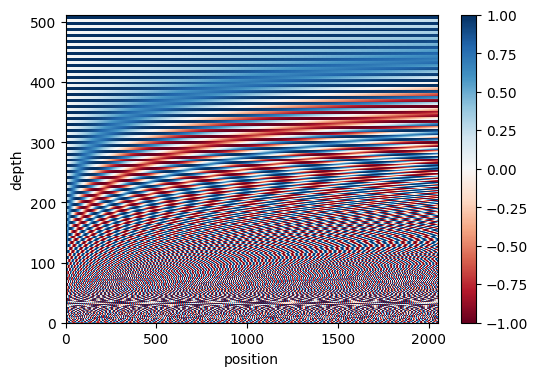

In [30]:
plt.figure(figsize = (6, 4))
plt.pcolormesh(tf.transpose(sample_enc), cmap = 'RdBu')
plt.xlabel('position')
plt.ylabel('depth')
plt.colorbar()
plt.show();

We can easily see that the vector is different at different positions. We can also visualize the difference between two vectors as we move away from one by taking the dot product. Here we take the vector at pos = 1000 and compare it with the vectors at rest of the positions.

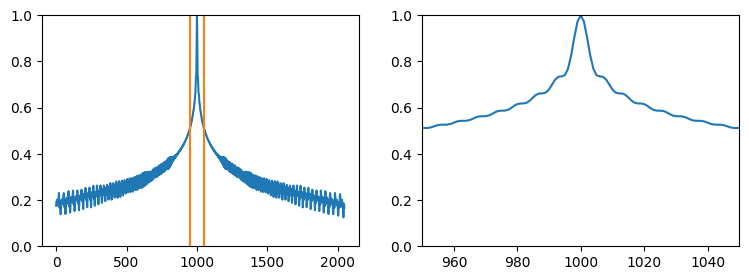

In [31]:
p_norm = tf.linalg.l2_normalize(sample_enc[1000][tf.newaxis, :])
sample_enc_norm = tf.linalg.l2_normalize(sample_enc, axis = 1)
dots = tf.linalg.matmul(sample_enc_norm, p_norm, transpose_b = True)

plt.figure(figsize = (9, 3))
plt.subplot(1, 2, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot([950, 950, float('nan'), 1050, 1050], [0, 1, float('nan'), 0, 1])

plt.subplot(1, 2, 2)
plt.plot(dots)
plt.ylim([0, 1])
plt.xlim([950, 1050])
plt.show()

We can see that the vectors are able to capture the essence of positions of the words.

Now we can write an embedding class which includes learnt embedding and positional embedding and add them to get the output.

In [32]:

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_enc = positional_encoding(length = 2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x_emb = self.embedding(x)
        x_pos_enc = self.pos_enc[:, :length, :]

        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb

In [33]:
sample_pos_emb = PositionalEmbedding(vocab_size, d_model = 512)
cap_emb = sample_pos_emb(cap)
print(cap_emb.shape)

(64, 34, 512)


**What is attention ?**

In simple words, Attention is the probability of a context vector (word in case of sentence , segment of image in case of images) associated with a word.

**Types of attention:**

**1.Cross Attention:** When Q is from a different set of vectors than K and V. For example, in our case, Q is vectors from image after passing through mobilenet model whereas K, V are vectors corresponding to input text to decoder.

**2.Self Attention: **When Q, K, V are from same vectors. (Present in Transformer encoder in Neural Machine translation case.)

**3.Causal Self Attention:** When Q, K, V are from same vectors but while calculating attention scores, we mask the words that appear after the word for which we are finding attention values. This is done whenever we are generating text so it is in transformer decoder part.

If we allow the word to see all the words, model will learn to predict the predict the word at next index just by looking at it and will not learn any contextual and structural meaning of sentence.

In [34]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

In [35]:
class CausalAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query = x,
                               key = x,
                               value = x,
                               use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [36]:
sample_csa = CausalAttention(num_heads = 8, key_dim = 512)
sample_csa_out = sample_csa(cap_emb)
print(sample_csa_out.shape)

(64, 34, 512)


In [37]:
class CrossAttention(BaseAttention):
    def call(self, context, x):
        attn_out, attn_scores = self.mha(query = x,
                                         key = context,
                                         value = context,
                                         return_attention_scores = True)

        self.last_attention_scores = attn_scores

        x = self.add([x, attn_out])
        x = self.layernorm(x)
        return x

**Transformer Encoder:**

As the image vectorizer is not getting trained, and I am not using any augumentation so we can pre calculate all the image feature vectors and store it in form of tensorflow dataset. So, the transformer encoder part is not getting trained and has fixed weights.

**Transformer Decoder:**

The input is transformer decoder is right-shifted allowing teacher forcing.

What is right-shifted input and teacher forcing ?

So, lets say for an image, we try our model to train the caption “The dogs are running in the park”

So, after preprocessing, the text will change to
“[START] The dogs are running in the park [END]”.

Now, for our decoder:

input: “[START] The dogs are running in the park”

target: “The dogs are running in the park [END]”
So, when for each word, we are keeping next word as our target allowing our model to learn the next word.

But let’s say, we input to our model “[START]”, if we get “We” instead of “The”, shouldn’t we continue with the word “We”. So, even if we are predicting the word wrong, why are we taking the correct output as the next word.

This is called Teacher forcing. As, we start training our model, our model is quite weak and therefore has less probability of predicting correct words. Now, we continue with the wrong prediction, it can cumulatively increase our error. So,in order to train faster, we can use teacher forcing.

Also, other main reason for teacher forcing is that it allows for parallelization. If we continue with the word that we have predicted, we have to wait for the model output for that word and then append it to the input for the next word. This leads to follow sequential and time consuming process. So, instead we can use teacher forcing which allows all the words to be inputted at same time.

We have talked a lot about theory, let’s see some code.

In [38]:
img_ = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img.shape, img_.shape)

sample_ca = CrossAttention(num_heads = 8, key_dim = 512)
sample_ca_out = sample_ca(context = img_, x = sample_csa_out)
print(sample_ca_out.shape)

(64, 7, 7, 576) (64, 49, 576)
(64, 34, 512)


Before looking at Decoder Layer code, let’s look at Feed Forward Network code, which follows the same architecture as in paper “Attention is all you need.”

In [39]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(rate = dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

In [40]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)

(64, 34, 512)


In [41]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)

(64, 34, 512)


Stacking up multiple decoder layer to get Decoder Architecture:

In [42]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(num_heads = num_heads,
                                                key_dim = d_model,
                                                dropout = dropout_rate)
        self.cross_attention = CrossAttention(num_heads = num_heads,
                                              key_dim = d_model,
                                              dropout = dropout_rate)
        self.ffn = FeedForward(d_model = d_model,
                               dff = dff,
                               dropout_rate = dropout_rate)
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.causal_attention(x)
        x = self.cross_attention(context = context, x = x)
        x = self.ffn(x)
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x

In [43]:
sample_decoder_layer = DecoderLayer(d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.2)
sample_decoder_layer_out = sample_decoder_layer(context = img_, x = cap_emb)
print(sample_decoder_layer_out.shape)

(64, 34, 512)


In [44]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens = ('', '[UNK]', '[START]')):
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation = tf.nn.log_softmax)

    def adapt(self, cap_ds):
        word_idx = {word : idx for idx, word in enumerate(self.vocab)}
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros((len(self.vocab), ))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1
        log_p = np.log(counts_prob)

        entropy = (-counts_prob*log_p).sum()

        print(f'uniform_entropy : {np.log(len(self.vocab))}')
        print(f'curr_entropy : {entropy}')
        log_p[counts_arr == 0] = -1e9

        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        return self.dense_layer(x) + self.bias

In [45]:
vocab = vectorizer.get_vocabulary()
sample_output_layer = OutputLayer(vocab)
sample_output_layer.adapt(train_ds.map(lambda img, cap: cap))
sample_output_layer_out = sample_output_layer(sample_decoder_layer_out)
print(sample_output_layer_out.shape)

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457
(64, 34, 5000)


In [46]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.num_layers = num_layers

        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context = context, x = x)

        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x

In [47]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

img_features = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img_features.shape)

(64, 7, 7, 576)
(64, 34)
(64, 34)
(64, 49, 576)


In [48]:
%%time
sample_decoder = Decoder(num_layers = 6, num_heads = 8, d_model = 512, dff = 2048)
sample_decoder_output = sample_decoder(context = img_features, x = cap)
print(sample_decoder_output.shape)
print(sample_decoder.last_attention_scores.shape)

(64, 34, 512)
(64, 8, 34, 49)
CPU times: user 773 ms, sys: 30.7 ms, total: 804 ms
Wall time: 1.31 s


In [49]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len =  50, dropout_rate = 0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.vectorizer = vectorizer
        self.output_layer = output_layer
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)
        self.max_len = pred_max_len
        self.vocab = self.vectorizer.get_vocabulary()

    def call(self, inputs):
        context, cap = inputs
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])


        x = self.decoder(context = context, x = cap)
        x = self.output_layer(x)
        return x

In [50]:
%%time
sample_captioner = Captioner(vectorizer = vectorizer,
                             feature_extractor = feature_extractor,
                             output_layer = sample_output_layer,
                             num_layers = 6,
                             num_heads = 8,
                             d_model = 512,
                             dff = 2048,
                             dropout_rate = 0.2)

print(sample_captioner((img, cap)).shape)
print(cap_labels.shape)
print(sample_captioner.summary())

(64, 34, 5000)
(64, 34)
Model: "captioner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 text_vectorization (TextVe  multiple                  0         
 ctorization)                                                    
                                                                 
 output_layer (OutputLayer)  multiple                  2565000   
                                                                 
 decoder_1 (Decoder)         multiple                  119139328 
                                                                 
Total params: 122643448 (467.85 MB)
Trainable params: 121704328 (464.27 MB)
Non-trainable params: 939120 (3.58 MB)
__________________________________________________

In [51]:
d_model = 128
dff = 128
dropout_rate = 0.4
num_layers = 2
num_heads = 2
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457


In [52]:
for (img_feature, cap), cap_labels in train_ds.take(1):
    break
print(img_feature.shape)
print(cap.shape)
print(cap_labels.shape)

(64, 7, 7, 576)
(64, 34)
(64, 34)


In [53]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

print(captioner_model((img_feature, cap), training = False).shape)
captioner_model.summary()

(64, 34, 5000)
Model: "captioner_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 text_vectorization (TextVe  multiple                  0         
 ctorization)                                                    
                                                                 
 output_layer_1 (OutputLaye  multiple                  645000    
 r)                                                              
                                                                 
 decoder_2 (Decoder)         multiple                  1694208   
                                                                 
Total params: 3278328 (12.51 MB)
Trainable params: 2339208 (8.92 MB)
Non-trainable params: 939120 (3.58 MB

In [54]:
@Captioner.add_method
def generate_text(self, img, temperature = 0.5):
    if img.shape[-1] == 3:
        img = self.feature_extractor(img)
    start_token = text_to_id_vectorizer([['[START]']])

    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    for i in range(self.max_len):
        preds = self((img, start_token))
        preds = preds[:, -1, :]
        if temperature == 0.0:
            pred_idx = tf.argmax(preds, axis = -1)[:, tf.newaxis]
        else:
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples = 1)

        start_token = tf.concat([start_token, pred_idx], axis = -1)

        if pred_idx[0][0] == end_idx:
            break

    return id_to_text(start_token).numpy()[0].decode('utf-8')

The most simple way to understand these scores are that the BLEU score is based on the precision, ROUGE score is based on recall and F score is the harmonic mean of BLEU score and ROUGE score.

In the code : “can” means y_predicted and “ref” means y_actual.

Brevity penalty is used to penalize score if the “can” is smaller then “ref”.
Why is this needed ?
Let’s say, the actual output is “He is running in the park” and output is “the” only. Then, just by precision score, as the word “the” is present in actual sentence, it will end up getting 1.0 bleu score even though the prediction is not correct. To deal with such issues, we multiply out raw bleu score with brevity penalty.

In [55]:
def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total
def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

In [56]:
@Captioner.add_method
def f_score(self, can, refs, n_gram_range = 1):
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range)  for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2*b_score*r_score) / (b_score + r_score))

    return max(f_vals)

The final output layer:

I came across this part of code while going through the information of the image captioning. I read this from here.

So, we if we just keep our final layer as Dense(vocab_size), then the weights are initialized using uniform distribution, which gives us maximum entropy (entropy = -p*log(p)). But we initialize out weights, based on the frequency of words then it acts as a better initializer. Also, we can keep add higg negative bias that we do not want in our output prediction i.e. [START], pad_token, [UNK].

This initialization of weights is quite nice and I liked it a lot.

But if you want, you can just keep it simply Dense(vocab_size) and your model will still work properly.

Now we can stack all the layers together and create our entire architecture.

Loss and Accuracy function:

For calculating loss and accuracy function, we use a mask that masks all the padded tokens so that it does not impact the loss value.

In [57]:
def masked_loss(labels, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    preds = tf.cast(tf.argmax(preds, axis = -1), tf.float32)
    labels = tf.cast(labels, tf.float32)
    mask = tf.cast(labels != 0, tf.float32)
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)

In [58]:
for (img, cap), cap_labels in train_ds.take(1):
    break
print(img.shape)
print(cap.shape)
print(cap_labels.shape)

preds = captioner_model((img, cap))
print(preds.shape)

print(masked_loss(cap, preds))
print(masked_accuracy(cap, preds))

(64, 7, 7, 576)
(64, 37)
(64, 37)
(64, 37, 5000)
tf.Tensor(5.5230193, shape=(), dtype=float32)
tf.Tensor(0.1388518, shape=(), dtype=float32)


tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
(224, 224, 3)
['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']


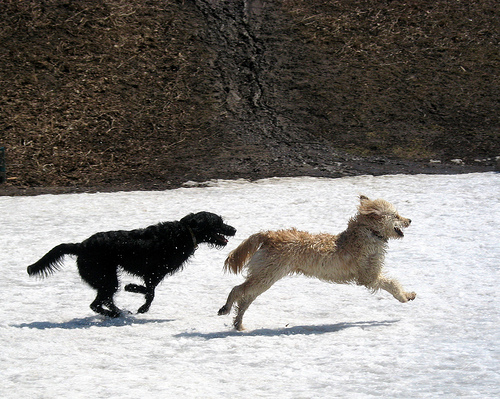

In [59]:
for img_path, caps in train_raw.take(1):
    break
print(img_path)
img = load_img(img_path)
print(img.shape)
caps = [cap.numpy().decode('utf-8') for cap in caps]
print(caps)
Image.open(img_path.numpy().decode('utf-8'))

In [60]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self, img = img):
        self.image = img[tf.newaxis, ...]
        self.caps = caps

    def on_epoch_end(self, epochs = None, logs = None):
        print('\n')
        for temp in (0, 0.5, 1):
            gen_text = self.model.generate_text(self.image)
            f_val = self.model.f_score(gen_text, self.caps, n_gram_range = 1)
            print(f'Generated_text: {gen_text}, \t f_score: {f_val}')

In [61]:
sample_gen_text = GenerateText()
sample_gen_text.model = captioner_model
sample_gen_text.on_epoch_end(0)




Generated_text: dog a a in a a a a, 	 f_score: 0
Generated_text: , 	 f_score: 0
Generated_text: a the a his the, 	 f_score: 0


In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
callbacks = [GenerateText(),
             tf.keras.callbacks.EarlyStopping(patience = 6, restore_best_weights = True)]

In [63]:
captioner_model.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])

In [64]:
hist = captioner_model.fit(
    train_ds.repeat(),
    steps_per_epoch = 100,
    validation_data = test_ds.repeat(),
    validation_steps = 20,
    #epochs = 150,
    epochs=50,
    callbacks = callbacks
)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.0919 - masked_accuracy: 0.1814

Generated_text: a dog on a dog, 	 f_score: 0
Generated_text: a dog, 	 f_score: 0
Generated_text: a wearing a dog and a dog in the dog is in a dog and the, 	 f_score: 0.41379310344827586
100/100 [==============================] - 27s 135ms/step - loss: 5.0919 - masked_accuracy: 0.1814 - val_loss: 4.7586 - val_masked_accuracy: 0.2304
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7335 - masked_accuracy: 0.2357

Generated_text: a boy in the small dog in a a a dog of a large dog, 	 f_score: 0.3571428571428571
Generated_text: a dog, 	 f_score: 0
Generated_text: a dog, 	 f_score: 0
100/100 [==============================] - 9s 90ms/step - loss: 4.7329 - masked_accuracy: 0.2358 - val_loss: 4.5459 - val_masked_accuracy: 0.2500
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.5105 - masked_accuracy: 0.2586

Generated_text: a dog in a dog, 	 f_sc

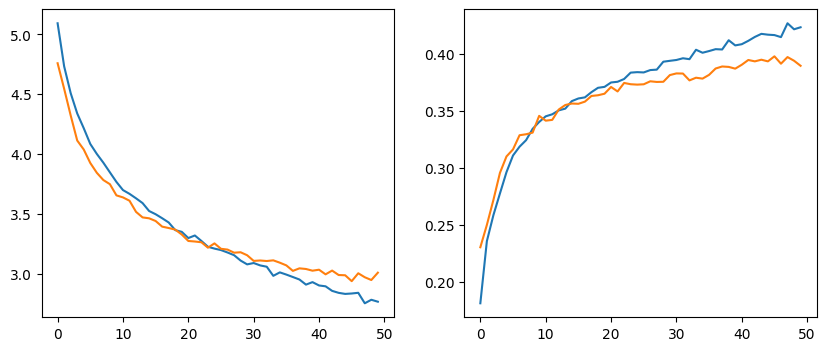

In [65]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['masked_accuracy'], label = 'masked_accuracy')
plt.plot(hist.history['val_masked_accuracy'], label = 'val_masked_accuracy')
plt.show()

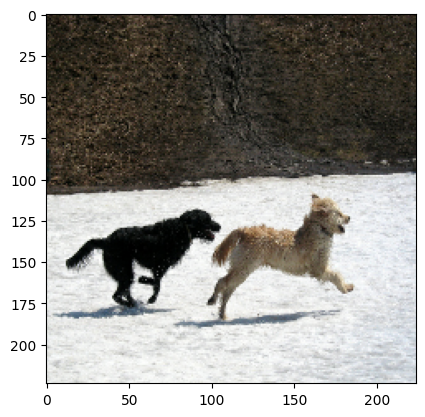

Generated Caption: two dogs are running through the snow


In [66]:
for img_path, caps in train_raw.batch(4).take(1):
    break

img = load_img(img_path[0].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

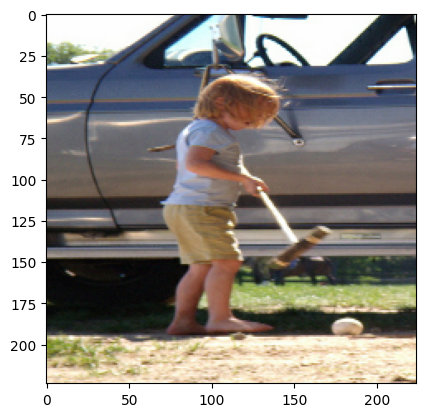

Generated Caption: a little girl in a blue shirt is standing on a fence


In [67]:
img = load_img(img_path[1].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

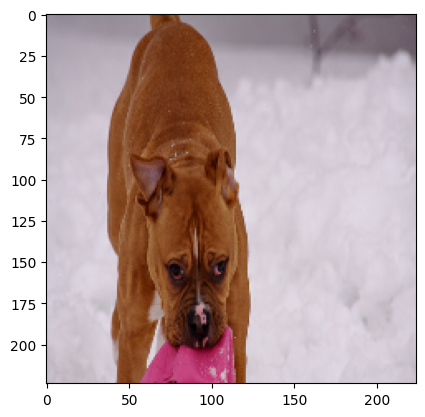

Generated Caption: a brown dog is running down a pink toy


In [68]:
img = load_img(img_path[2].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

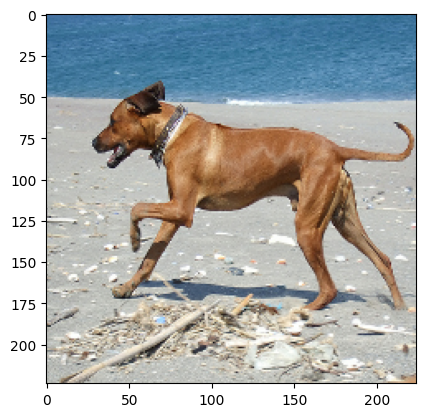

Generated Caption: a brown dog is jumping on a beach


In [69]:
img = load_img(img_path[3].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

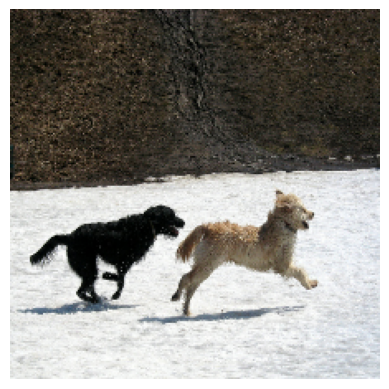

two dogs run through the snow


In [70]:
for img_path, cap in train_raw.take(1):
    break
img = load_img(img_path)
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])

plt.imshow(img/255)
plt.axis('off')
plt.show()
print(cap_gen)

In [71]:
cap_gen_tokens = cap_gen.split() + ['[END]']
print(len(cap_gen_tokens))

7


In [72]:
attn_scores = captioner_model.decoder.last_attention_scores
print(attn_scores.shape)
attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')
print(attn_maps.shape)

(1, 2, 7, 49)
(7, 7, 7)


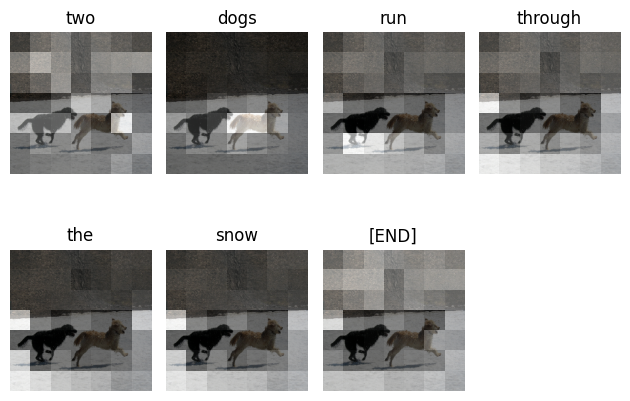

In [73]:
len_result = len(attn_maps)
col_len = int(np.ceil(len_result/2))
row_len = 2

for i in range(len_result):
    ax = plt.subplot(row_len, col_len, i+1)
    img_plot = ax.imshow(img/255)
    plt.title(cap_gen_tokens[i])
    ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

For training, I am keeping stack of 2 decoder layers, embedding dimension and model dimension as 128. I am training model for 50 epochs.

To generate text, I am using temperature based random sampling which allows model to generate text in ways other than the greedy approach.

After training my model, I am getting F-1(for unigrams) score of 0.5 which is quite good.

In [74]:
@Captioner.add_method
def show_attention(self, img, temperature = 0.5):
    gen_text = self.generate_text(img = img[tf.newaxis, ...], temperature = temperature)
    cap_gen_tokens = cap_gen.split() + ['[END]']
    # Here we are adding [END] token as while printing text using id_to_text, it filters out [END] token even though it is generated.
    attn_scores = captioner_model.decoder.last_attention_scores
    attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')

    len_result = len(attn_maps)
    col_len = int(np.ceil(len_result/2))
    row_len = 2

    for i in range(len_result):
        ax = plt.subplot(row_len, col_len, i+1)
        img_plot = ax.imshow(img/255)
        plt.title(cap_gen_tokens[i])
        ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
        plt.axis('off')

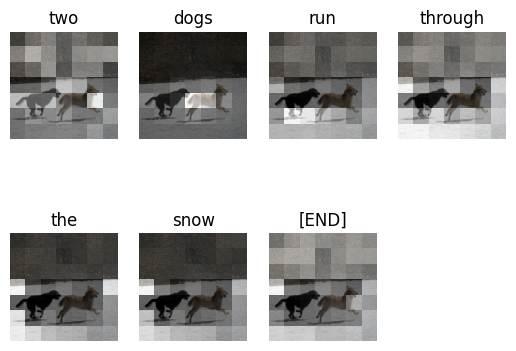

In [75]:
captioner_model.show_attention(img)